Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50] Training: Loss: 1.1187, Accuracy: 61.46%, Validation: Loss: 0.9038, Accuracy: 69.55%
Epoch [2/50] Training: Loss: 0.7545, Accuracy: 74.30%, Validation: Loss: 0.6881, Accuracy: 75.86%
Epoch [3/50] Training: Loss: 0.6486, Accuracy: 77.51%, Validation: Loss: 0.6287, Accuracy: 78.20%
Epoch [4/50] Training: Loss: 0.6006, Accuracy: 79.33%, Validation: Loss: 0.6031, Accuracy: 79.33%
Epoch [5/50] Training: Loss: 0.5350, Accuracy: 81.55%, Validation: Loss: 0.5779, Accuracy: 80.74%
Epoch [6/50] Training: Loss: 0.4980, Accuracy: 82.59%, Validation: Loss: 0.5632, Accuracy: 80.92%
Epoch [7/50] Training: Loss: 0.4757, Accuracy: 83.48%, Validation: Loss: 0.5469, Accuracy: 81.16%
Epoch [8/50] Training: Loss: 0.4545, Accuracy: 84.21%, Validation: Loss: 0.5745, Accuracy: 80.95%
Epoch [9/50] Training: Loss: 0.4317, Accuracy: 84.93%, Validation: Loss: 0.5186, Accuracy: 82.59%
Epoch [10/50] Training: Loss: 0.4025, Accu

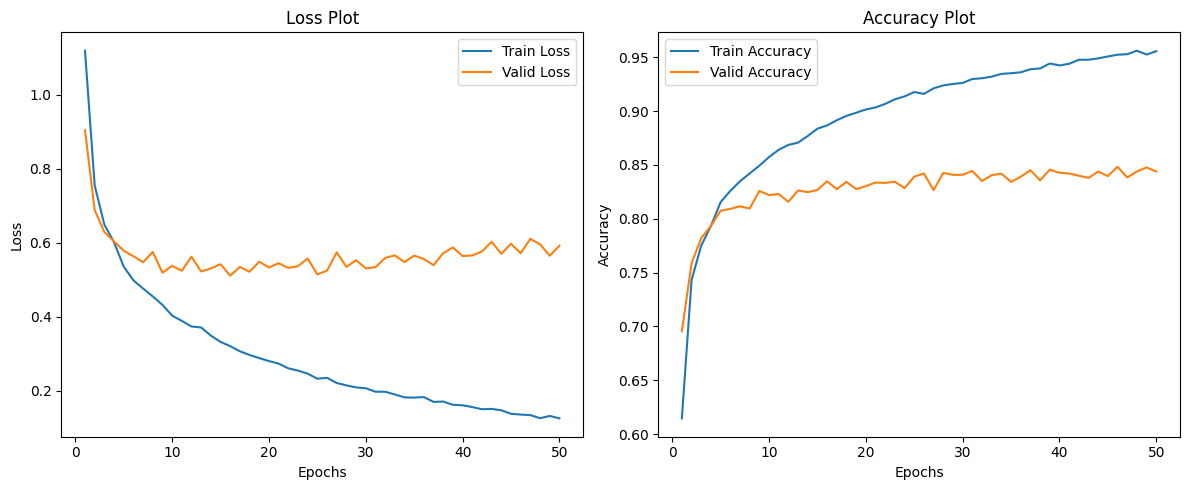

Epoch [1/50] Training: Loss: 1.6484, Accuracy: 38.21%, Validation: Loss: 1.2881, Accuracy: 53.81%
Epoch [2/50] Training: Loss: 1.1874, Accuracy: 58.56%, Validation: Loss: 1.2631, Accuracy: 56.42%
Epoch [3/50] Training: Loss: 0.9575, Accuracy: 67.54%, Validation: Loss: 0.9398, Accuracy: 67.39%
Epoch [4/50] Training: Loss: 0.8281, Accuracy: 72.88%, Validation: Loss: 0.8093, Accuracy: 73.45%
Epoch [5/50] Training: Loss: 0.7255, Accuracy: 76.55%, Validation: Loss: 0.6744, Accuracy: 76.99%
Epoch [6/50] Training: Loss: 0.6503, Accuracy: 79.50%, Validation: Loss: 0.5758, Accuracy: 80.76%
Epoch [7/50] Training: Loss: 0.5939, Accuracy: 81.16%, Validation: Loss: 0.6145, Accuracy: 80.15%
Epoch [8/50] Training: Loss: 0.5445, Accuracy: 82.92%, Validation: Loss: 0.5805, Accuracy: 80.43%
Epoch [9/50] Training: Loss: 0.5022, Accuracy: 84.35%, Validation: Loss: 0.5777, Accuracy: 81.41%
Epoch [10/50] Training: Loss: 0.4677, Accuracy: 85.27%, Validation: Loss: 0.4894, Accuracy: 84.00%
Epoch [11/50] Train

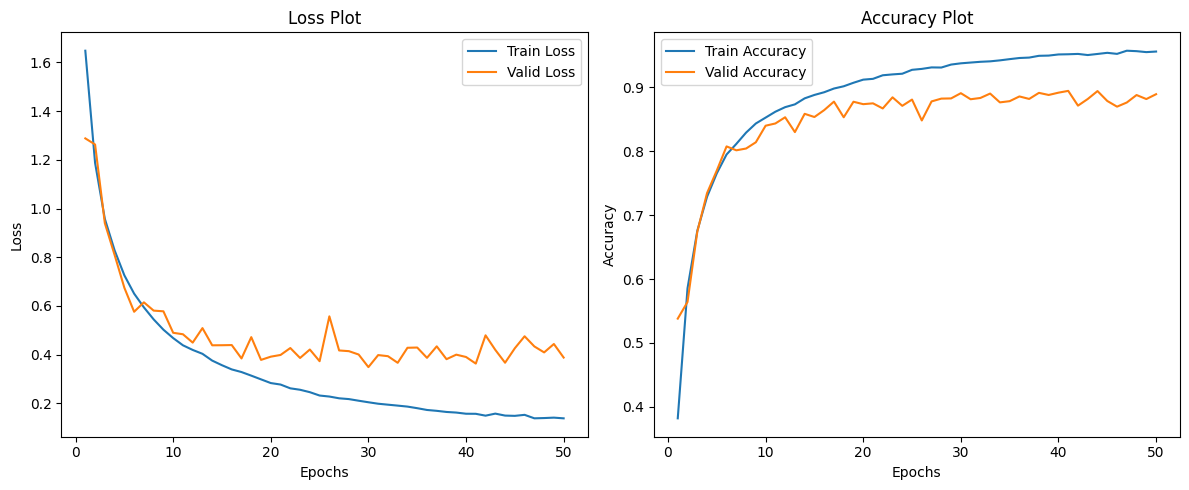

Ensemble Test Accuracy: 90.61%


In [7]:
# 模型融合
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.models as models
# 融合函数
# 融合函数
def ensemble(models_set, images, device):
    """进行模型融合"""
    outputs = [m(images) for m in models_set]
    avg_output = sum(outputs) / len(models_set)  # 计算加权平均
    return avg_output
# 模型集合
models_set = []

# 使用自己定义的CNN：
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRRR(nn.Module):
    def __init__(self):
        super(RRRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.01
lr_2 = 0.001
epochs = 50

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(num_epochs, mod, optimizer):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    for epoch in range(num_epochs):
        mod.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = mod(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            mod.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = mod(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        # 绘制损失曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plot')
    plt.legend()

    plt.tight_layout()
    plt.show()


# 加载本地的预训练权重
checkpoint_path = "/root/autodl-tmp/CNN/resnet18-f37072fd.pth"
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=10)

# 加载 resnet参数
checkpoint = torch.load(checkpoint_path)
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model.state_dict() and model.state_dict()[k].shape == v.shape}
model.load_state_dict(pretrained_dict, strict=False)
model = model.to(device)
optimizer1 = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)  # 添加权重衰减以增强正则化
models_set.append(model)
train(epochs,mod=model,optimizer=optimizer1) # 训练


# 加载 RRRR参数
model_2 = RRRR().to(device)
optimizer2 = optim.Adam(model_2.parameters(), lr=lr_2, weight_decay=1e-4)  # 添加权重衰减以增强正则化
models_set.append(model_2)
train(epochs,mod=model_2,optimizer=optimizer2) # 训练



# 执行训练和评估
def test_ensemble(models_set):
    """测试融合模型的准确性"""
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = ensemble(models_set, images, device)  # 修改此处
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Ensemble Test Accuracy: {100 * correct / total:.2f}%")
    


# 执行融合测试
test_ensemble(models_set)


